#### This kernel used dataset from the Home Credit Default Risk and copied from the 'EDA + Baseline Model' written by AiswaryaRamachandran.

**Introduction to 'EDA + Baseline Model': [URL](https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse/notebook)**

*Thanks for sharing kernel, AiswaryaRamachandran*

---------------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import zipfile

In [2]:
zf_train = zipfile.ZipFile('../input/nyc-taxi-trip-duration/train.zip')
train = pd.read_csv(zf_train.open('train.csv'))

zf_test = zipfile.ZipFile('../input/nyc-taxi-trip-duration/test.zip')
test = pd.read_csv(zf_test.open('test.csv'))

#### Convert to appropriate datatype
convert pickup datetime adn dropoff datetime into date-time object

In [3]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Are there any missing values in the data?

In [4]:
# version 1
train[pd.isnull(train)].sum()

id                    0  
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0  
trip_duration         0.0
dtype: object

In [5]:
# version 2
train.any()

id                    True
vendor_id             True
pickup_datetime       True
dropoff_datetime      True
passenger_count       True
pickup_longitude      True
pickup_latitude       True
dropoff_longitude     True
dropoff_latitude      True
store_and_fwd_flag    True
trip_duration         True
dtype: bool

In [6]:
# version 3
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### What is the time period of the dataset?

In [7]:
print("Min pickup time:",min(train['pickup_datetime']))
print("Max pickup time:",max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


#### create new day,month, hour info from Pickup time

In [8]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x : x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x : x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x : calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x : x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x : x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

#### Round lat lng to 3 decimal places

In [9]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x : round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))

train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x : round(x, 3))
train['dropoff_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))

#### Based on Latitude and Longitude get the distance of the trip in km
This uses Haversine Distance

In [10]:
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = sin(dlat / 2)** 2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [11]:
train['trip_distance'] = train.apply(lambda row : calculateDistance(row), axis =1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.982,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.980,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-73.979,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.010,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [12]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x : x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.982,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.980,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-73.979,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.010,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


#### Exploratory Analysis

Text(0.5, 0, 'trip duration (in hour)')

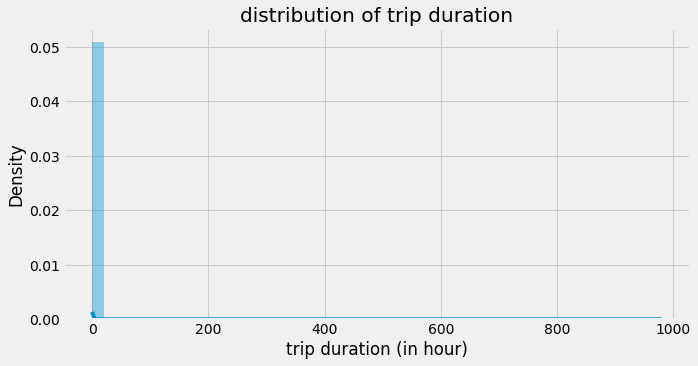

In [13]:
plt.figure(figsize = (10, 5))
sns.distplot(train['trip_duration_in_hour']).set_title('distribution of trip duration')
plt.xlabel('trip duration (in hour)')

In [14]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.790,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.922,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.984,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.784,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well

Text(0.5, 1.0, 'distribution of trip duration (sec) in log scale')

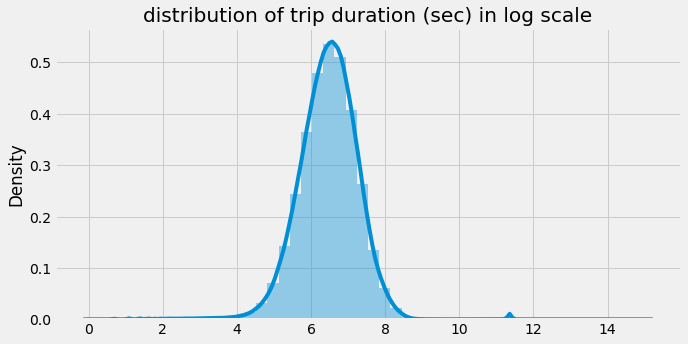

In [15]:
plt.figure(figsize = (10,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('distribution of trip duration')
plt.title('distribution of trip duration (sec) in log scale')

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are within New York

#### Heatmap of common locations from where pickup and dropoff occurs

In [16]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [17]:
pickup['Num_Trips'] = pickup['Num_Trips'].astype('float64')

In [18]:
# TypeError: Object of type 'int64' is not JSON serializable

# You can change that specific columns with int dtype to float64, as example:

In [19]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, 
                           pickup.pickup_longitude_round3.values,
                           pickup.Num_Trips.values)),
                  min_opacity = 0.2,
                  radius = 5, blur = 15,
                  max_zoom = 1)

pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

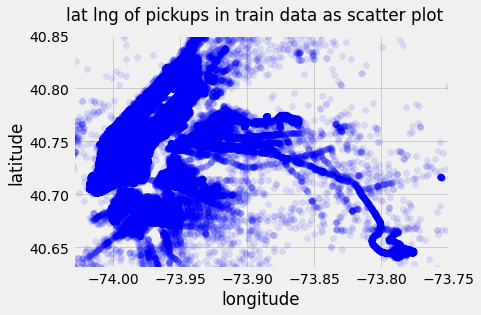

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color = 'blue', label = 'train', alpha = 0.1)

fig.suptitle('lat lng of pickups in train data as scatter plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### This graph clearly shows heavy density of pickups near JFK

In [21]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [22]:
# TypeError: Object of type 'int64' is not JSON serializable

# You can change that specific columns with int dtype to float64, as example:

for col in drop.columns:
    if drop[col].dtype != 'float64':
        drop[col] = drop[col].astype('float64')

In [23]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1)

drop_map.add_child(hm_wide)
drop_map

#### heatmap of trip duration, when pickup originates from a point

In [24]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'Avg_Trip_duration'})

In [25]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values,
                           pickup.pickup_longitude_round3.values,
                           pickup.Avg_Trip_duration.values)),
                  min_opacity = 0.2,
                  radoius = 7, blur = 15,
                  max_zoom = 1)

pickup_map.add_child(hm_wide)
pickup_map

#### which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'pickup hours distribution')

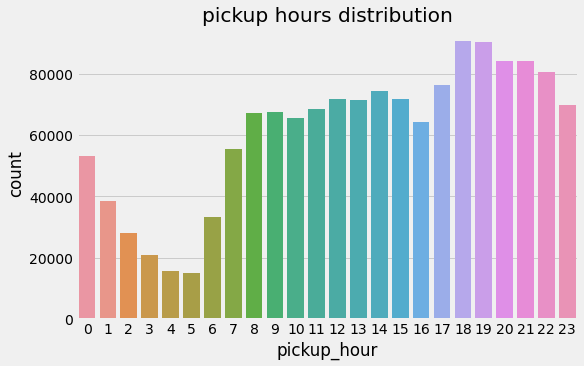

In [26]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['pickup_hour']).set_title('pickup hours distribution')

Text(0.5, 1.0, 'dropoff hours distribution')

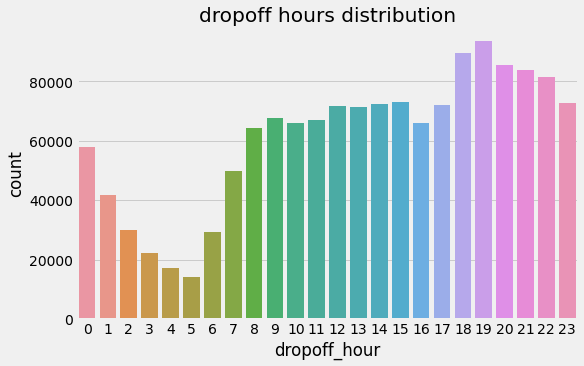

In [27]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['dropoff_hour']).set_title('dropoff hours distribution')

#### Pickups over the entire time period

Text(0.5, 1.0, 'distribution of pickups over time')

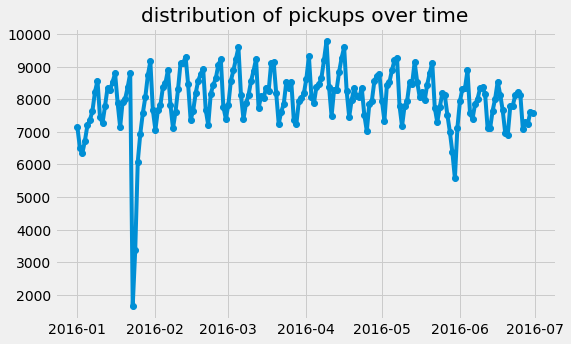

In [28]:
plt.figure(figsize = (8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')

plt.title('distribution of pickups over time')

#### What is the distribution of trip distance

In [29]:
train['trip_distance'].values

array([1.4989912 , 1.80607396, 6.38710292, ..., 7.82706209, 1.09290687,
       1.13439796])

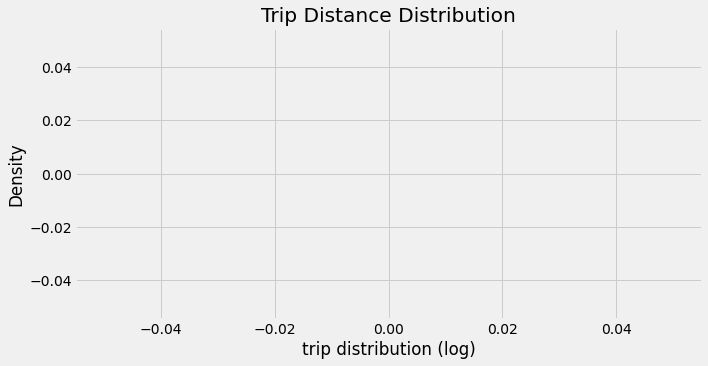

In [30]:
plt.figure(figsize = (10, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
#sns.kdeplot(np.log(train['trip_distance'].values)).set_title('trip distance distribution')
plt.xlabel('trip distribution (log)')
plt.show()

#### Trip Duration vs Trip Distance

Text(0, 0.5, 'trip distribution (log scale)')

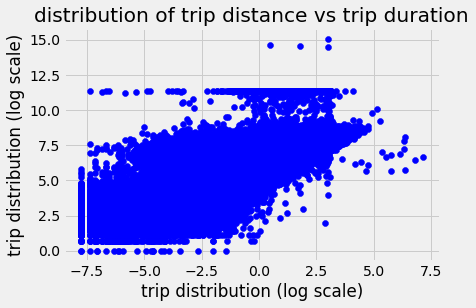

In [31]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color = 'blue', label = 'train')

plt.title('distribution of trip distance vs trip duration')
plt.xlabel('trip distribution (log scale)')
plt.ylabel('trip distribution (log scale)')

#### is the trip duration higher at diffent hours?

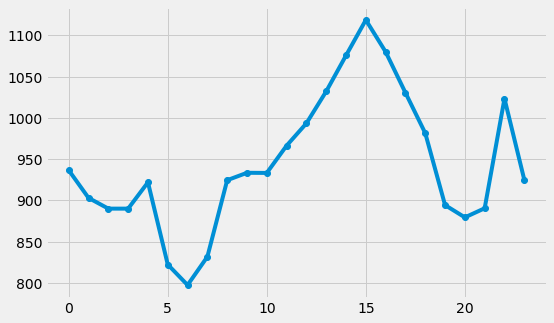

In [32]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8, 5))
plt.plot(avg_duration_hour['avg_trip_duration'], 'o-')

#### Distribution of pickups across days

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

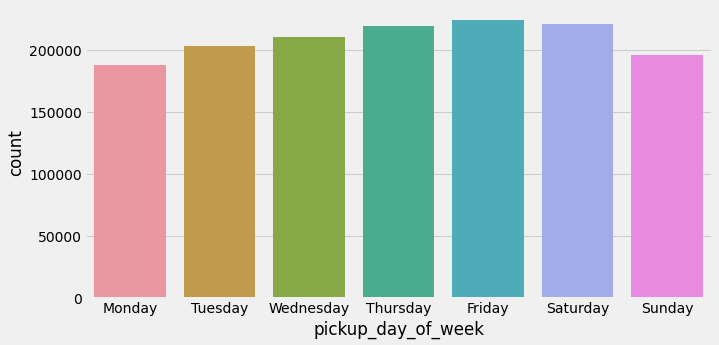

In [33]:
plt.figure(figsize = (10, 5))
sns.countplot(train['pickup_day_of_week'], order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

#### Avg Trip Duration over Days of week

Text(0.5, 1.0, 'avg trip duration vs pickup days of week')

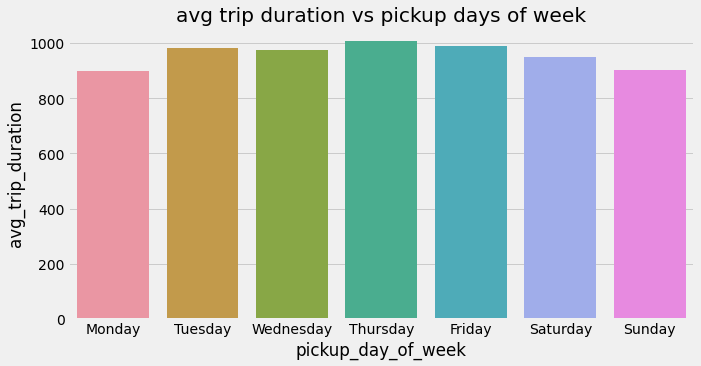

In [34]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})

plt.figure(figsize = (10, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_trip_duration', data = avg_duration_day,
            order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title('avg trip duration vs pickup days of week')

#### Create a caluclated field Bearing
Bearing measures the direction of travel The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude

In [35]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [36]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],
                                                         row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

#### Distribution of Bearing

In [37]:
train['pickup_latitude_round3']

0          40.768
1          40.739
2          40.764
3          40.720
4          40.793
            ...  
1458639    40.746
1458640    40.747
1458641    40.769
1458642    40.749
1458643    40.782
Name: pickup_latitude_round3, Length: 1458644, dtype: float64

<AxesSubplot:xlabel='bearing', ylabel='Density'>

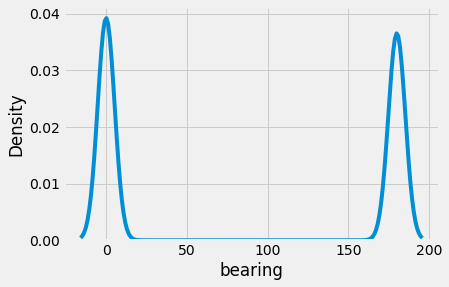

In [38]:
sns.kdeplot(train['bearing'])

#### Bearing vs trip duration

Text(0, 0.5, 'trip duration (log scale)')

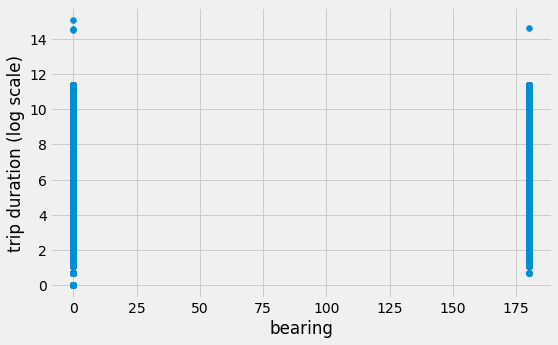

In [39]:
plt.figure(figsize = (8, 5))
plt.scatter(train['bearing'].values, y = np.log(train['trip_duration'].values))
plt.xlabel('bearing')
plt.ylabel('trip duration (log scale)')

#### Distribution of store and FWD Flag

In [40]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

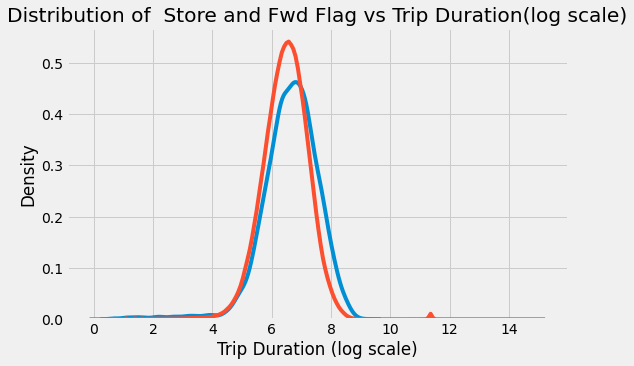

In [41]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

#### Group Locations into cluster
This will help creating neighbourhoods. And pickups from certain neightbourhoods may have a longer trip duration

(-74.03, -73.75)

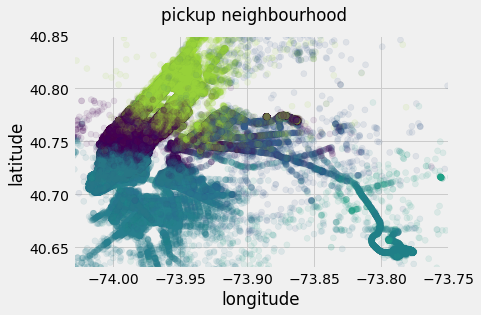

In [42]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                   train[['dropoff_latitude', 'dropoff_longitude']].values,
                   test[['pickup_latitude', 'pickup_longitude']].values,
                   test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 
                                                            'dropoff_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude',
                                                            'pickup_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c = train['pickup_neighbourhood'], label = 'train', alpha = 0.1)
fig.suptitle('pickup neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

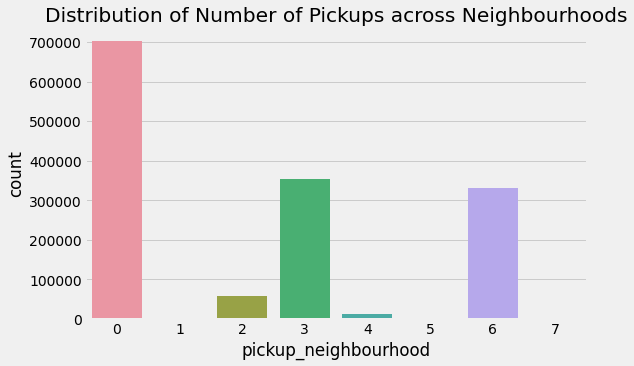

In [43]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'avg trip duration vs neighbourhood')

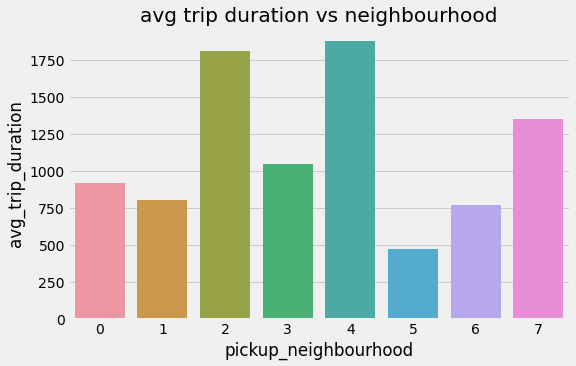

In [44]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_neighbourhood', y ='avg_trip_duration',
            data = avg_duration_neighbourhood).set_title('avg trip duration vs neighbourhood')

#### Distribution of Average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

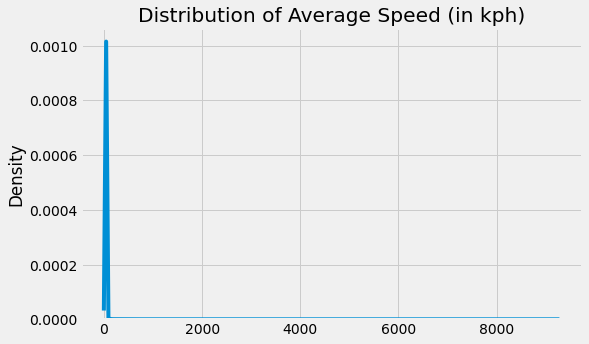

In [45]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [46]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458675 kph


#### Average Speed across days of week - this is indication of traffic speed.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

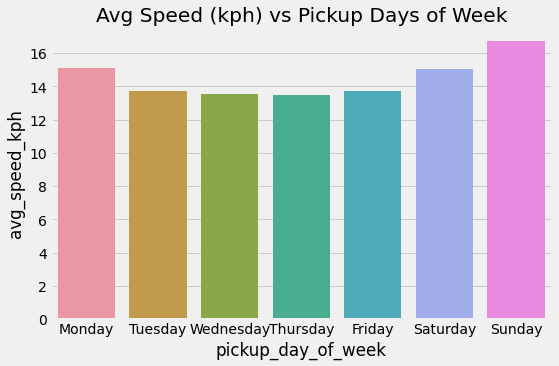

In [47]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

#### Feature Engineering on Test Data

In [48]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#### Building Models

From the training data we need to drop "dropoff datetime features". We also only keep lat lng rounded to 3 decimal places



In [49]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

In [50]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'], axis = 1, inplace = True)

In [51]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


In [52]:
def encodeDays(day_of_week):
    day_dict = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
                'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]

In [53]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [54]:
training.to_csv('input_training.csv', index = False)
testing.to_csv('input_testing.csv', index = False)
del training
del testing
del train
del test

In [55]:
def LabelEncoding(train_df, test_df, max_levels = 2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]


def readInputAndEncode(input_path,train_file,test_file,target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    
    training, testing = LabelEncoding(training, testing)
    
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    
    col_in_train_not_test = set(train_cols) - set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    
    print('training data shape after preprocessing: ', training.shape)
    print('testing data shape after preprocessing: ', testing.shape)
    return [training, testing]

In [56]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

training data shape after preprocessing:  (1458644, 18)
testing data shape after preprocessing:  (625134, 17)


In [57]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',
                        split=0.25,imputation=True):
    labels = np.array(train[target])
    training = train.drop(target, axis = 1)
    training = np.array(training)
    testing = np.array(test)
    
    if imputation == True:
        imputer = Imputer(strategy = imputing_strategy, missing_values = np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
        
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [58]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

### Apply Linear Regression

In [59]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)

LinearRegression()

In [60]:
valid_pred=lm.predict(validation_features)

In [61]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.39634753032371733


In [62]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False)
del submit

### Apply Random Forest Regressor

In [63]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

In [64]:
rf.fit(train_features,train_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [65]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.2007963543116804


In [66]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)